In [16]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline 
#plotting directly without requering the plot()

import warnings
warnings.filterwarnings(action="ignore") #ignoring most of warnings, cleaning up the notebook for better visualization

pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)

print(os.listdir("../input")) #showing all the files in the ../input directory

# Any results you write to the current directory are saved as output. Kaggle message :D

['sample_submission.csv', 'test.csv', 'train.csv']


** loading the training and testing dataset **

In [17]:
train = pd.read_csv('../input/train.csv', parse_dates=True, infer_datetime_format=True, dayfirst=True)
test = pd.read_csv('../input/test.csv', parse_dates=True, infer_datetime_format=True, dayfirst=True)

In [18]:
print('----- DETAILS of our DATASET -----')
print('Training shape: %s' %str(train.shape))
print('Testing shape: %s' %str(test.shape))
print('First date entry for the training dataset: %s' %train.index.min())
print('Last date entry for the training dataset: %s' %train.index.max())
print('First date entry for the testing dataset: %s' %test['date'].min())
print('Last date entry for the testing dataset: %s' %test['date'].max())
print('Number of unique items, training set: %s' %train['item'].nunique())
print('Number of unique items, testing set: %s' %test['item'].nunique())
train.head()

----- DETAILS of our DATASET -----
Training shape: (913000, 4)
Testing shape: (45000, 4)
First date entry for the training dataset: 0
Last date entry for the training dataset: 912999
First date entry for the testing dataset: 2018-01-01
Last date entry for the testing dataset: 2018-03-31
Number of unique items, training set: 50
Number of unique items, testing set: 50


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


**In order to make features engineering easier, let's create a dataframe with both testing and training set together**

In [19]:
# Concatenating train & test
train['split'] = 'train'
test['split'] = 'test'
df_total = pd.concat([train,test], sort=False)
print('Total shape: {}'.format(df_total.shape))
del train, test
gc.collect()
df_total.head()

Total shape: (958000, 6)


,date,store,item,sales,split,id
0,2013-01-01,1,1,13.0,train,NaN
1,2013-01-02,1,1,11.0,train,NaN
2,2013-01-03,1,1,14.0,train,NaN
3,2013-01-04,1,1,13.0,train,NaN
4,2013-01-05,1,1,10.0,train,NaN


Extracting all the information from the data given:

In [21]:
df_total['date'] = pd.to_datetime(df_total['date'], dayfirst=True,infer_datetime_format=True)
df_total['month'] = df_total['date'].dt.month
df_total['year'] = df_total['date'].dt.year
df_total['weekday'] = df_total['date'].dt.weekday
df_total['day_of_month'] = df_total['date'].dt.day
df_total['day_of_year'] = df_total['date'].dt.dayofyear
df_total.tail()

,date,store,item,sales,split,id,month,year,weekday,day_of_month,day_of_year
44995,2018-03-27,10,50,NaN,test,44995.0,3,2018,1,27,86
44996,2018-03-28,10,50,NaN,test,44996.0,3,2018,2,28,87
44997,2018-03-29,10,50,NaN,test,44997.0,3,2018,3,29,88
44998,2018-03-30,10,50,NaN,test,44998.0,3,2018,4,30,89
44999,2018-03-31,10,50,NaN,test,44999.0,3,2018,5,31,90


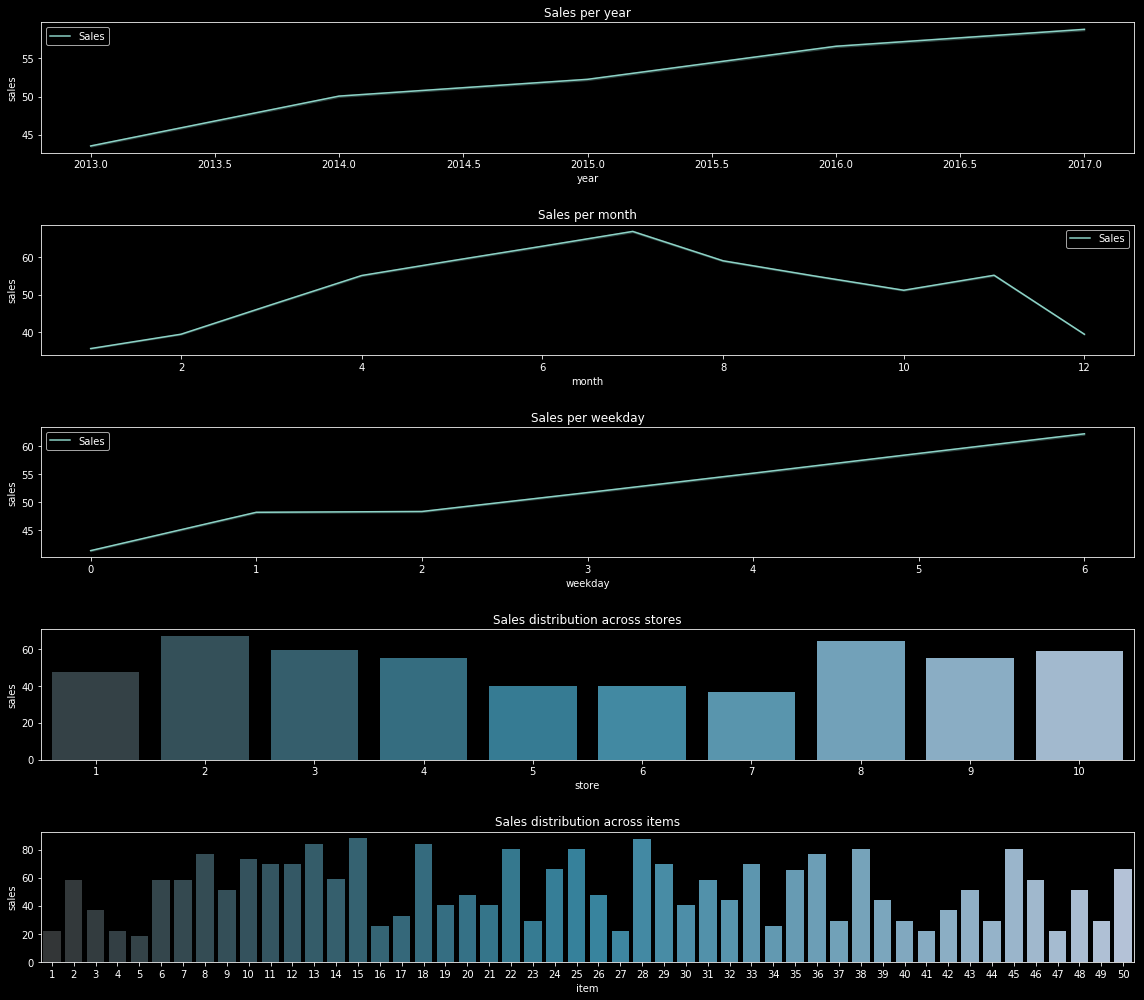

In [22]:
#sns.set_style('ticks') #setting the style for our plots
plt.style.use('dark_background') #another style,this one is from the matplotlib

fig = plt.figure(figsize=(16,14))

plt.subplot(5,1,1)
sns.lineplot(y='sales', x='year', data=df_total, label='Sales');plt.title('Sales per year')
plt.subplot(5,1,2)
sns.lineplot(y='sales', x='month', data=df_total, label='Sales');plt.title('Sales per month')
plt.subplot(5,1,3)
sns.lineplot(y='sales', x='weekday', data=df_total, label='Sales');plt.title('Sales per weekday')
plt.subplot(5,1,4)
sns.barplot(x=df_total['store'], y=df_total['sales'], errwidth=0,palette="PuBuGn_d");plt.title('Sales distribution across stores')
plt.subplot(5,1,5)
sns.barplot(x=df_total['item'], y=df_total['sales'], errwidth=0,palette="PuBuGn_d");plt.title('Sales distribution across items')
plt.tight_layout(h_pad=2.5)

** Some information that can be derived from the plots above: **


***


## Feature Engineering
### Grouping the items by month, creating a new feature for it.
### As the testing set has 3 months ahead, I am gonna be using 3 months before as the lag value, accordingly, I am gonna create features for the 3 months before in the training set, calculating the mean, std and trend.

In [23]:
# taking the log1+ of our target(sales)
df_total['sales'] = np.log1p(df_total.sales.values)

Text(0.5, 1.0, 'Distribution of sales log1p')

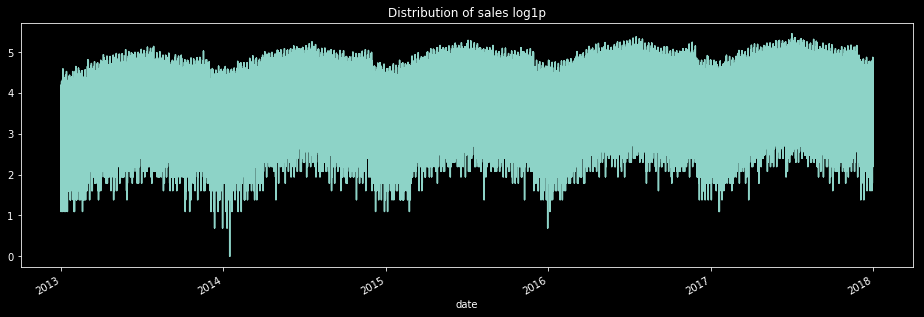

In [24]:
fig = plt.figure(figsize=(16,5))
df_total.set_index('date')['sales'].plot(); plt.title('Distribution of sales log1p')

#### Labeling the validation data that is gonna be used, every 3 months is gonna be used for validation starting in january
* Gonna separate the labels, our target for validation and training set

In [25]:
val_months = (df_total.year==2017) & (df_total.month.isin([1,2,3]))
skip = (df_total.year==2017) & (~val_months)
df_total.loc[(val_months), 'split'] = 'val'
df_total.loc[(skip), 'split'] = 'skip'
train = df_total.loc[df_total.split.isin(['train','val','test']), :]
train_labels = train.loc[train['split'] == 'train', 'sales'].values.reshape((-1))
train_labels_val = train.loc[train['split'] == 'val', 'sales'].values.reshape((-1))
print('Shape Training set: %s' %str(train[train['split']== 'train'].shape))
print('Shape Validation set: %s' %str(train[train['split']== 'val'].shape))
print('Shape Testing set: %s' %str(train[train['split']== 'test'].shape))
print('train labels(Y): %s' %str(train_labels.shape))
print('train labels for the validation set(Y_val): %s' %str(train_labels_val.shape))

Shape Training set: (730500, 11)
Shape Validation set: (45000, 11)
Shape Testing set: (45000, 11)
train labels(Y): (730500,)
train labels for the validation set(Y_val): (45000,)


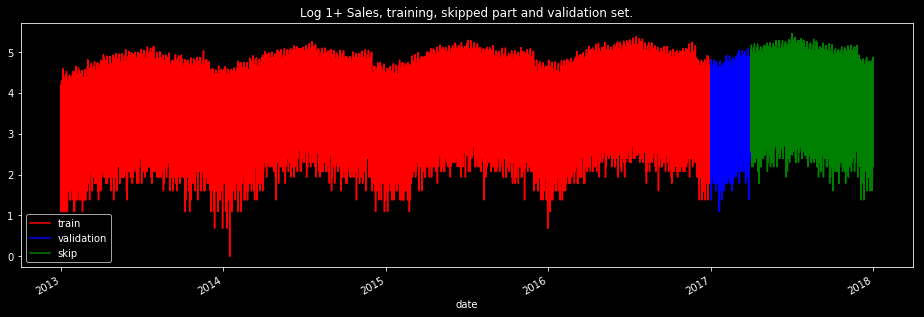

In [32]:
fig = plt.figure(figsize=(16,5))
df_total.set_index('date', inplace=True)
df_total.loc[df_total['split'] == 'train', 'sales'].plot(c='r', label='train')
df_total.loc[df_total['split'] == 'val', 'sales'].plot(c='b', label='validation')
df_total.loc[df_total['split'] == 'skip', 'sales'].plot(c='g', label='skip')
plt.title('Log 1+ Sales, training, skipped part and validation set.')
plt.legend()

In [33]:
lags=[91,98,105,112,119,126,182,364,546,728] #lag for previous months, 91 days until 728 days
alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5] #It's gonna be used for the exponential weighted moving average

train.loc[train['split'] == 'val', 'sales'] = np.nan 
#setting all the sales validation which is gonna be used for our transformation below, 
##this is gonna help our model generalize better
####we have saved our validation labels before, so it's ok

temp_groupby = train.groupby(['store','item'])

### creating lag features for the number of days in lag ###
for i in lags:
    train['_'.join(['sales', 'lag', str(i)])] = \
                temp_groupby['sales'].shift(i).values + np.random.normal(scale=1.6, size=(len(train),)) #normalizing term

### creating the exponential weighted average, using the same days as in lag ###
for a in alpha:
    for i in lags:
        train['_'.join(['sales', 'lag', str(i), 'ewm', str(a)])] = \
            temp_groupby['sales'].shift(i).ewm(alpha=a).mean().values

### creating the rolling mean for 1 year and 1 year and half ###
for w in [364,546]:
    train['_'.join(['sales', 'rmean', str(w)])] = \
            temp_groupby['sales'].shift(1).rolling(window=w, 
                                                  min_periods=10,
                                                  win_type='triang').mean().values +\
            np.random.normal(scale=1.6, size=(len(train),)) #normalizing term

del temp_groupby #--cleaning the memory up--
gc.collect()


0

In [34]:
train.head()

,date,store,item,sales,split,id,month,year,weekday,day_of_month,day_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_lag_91_ewm_0.95,sales_lag_98_ewm_0.95,sales_lag_105_ewm_0.95,sales_lag_112_ewm_0.95,sales_lag_119_ewm_0.95,sales_lag_126_ewm_0.95,sales_lag_182_ewm_0.95,sales_lag_364_ewm_0.95,sales_lag_546_ewm_0.95,sales_lag_728_ewm_0.95,sales_lag_91_ewm_0.9,sales_lag_98_ewm_0.9,sales_lag_105_ewm_0.9,sales_lag_112_ewm_0.9,sales_lag_119_ewm_0.9,sales_lag_126_ewm_0.9,sales_lag_182_ewm_0.9,sales_lag_364_ewm_0.9,sales_lag_546_ewm_0.9,sales_lag_728_ewm_0.9,sales_lag_91_ewm_0.8,sales_lag_98_ewm_0.8,sales_lag_105_ewm_0.8,sales_lag_112_ewm_0.8,sales_lag_119_ewm_0.8,sales_lag_126_ewm_0.8,sales_lag_182_ewm_0.8,sales_lag_364_ewm_0.8,sales_lag_546_ewm_0.8,sales_lag_728_ewm_0.8,sales_lag_91_ewm_0.7,sales_lag_98_ewm_0.7,sales_lag_105_ewm_0.7,sales_lag_112_ewm_0.7,sales_lag_119_ewm_0.7,sales_lag_126_ewm_0.7,sales_lag_182_ewm_0.7,sales_lag_364_ewm_0.7,sales_lag_546_ewm_0.7,sales_lag_728_ewm_0.7,sales_lag_91_ewm_0.6,sales_lag_98_ewm_0.6,sales_lag_105_ewm_0.6,sales_lag_112_ewm_0.6,sales_lag_119_ewm_0.6,sales_lag_126_ewm_0.6,sales_lag_182_ewm_0.6,sales_lag_364_ewm_0.6,sales_lag_546_ewm_0.6,sales_lag_728_ewm_0.6,sales_lag_91_ewm_0.5,sales_lag_98_ewm_0.5,sales_lag_105_ewm_0.5,sales_lag_112_ewm_0.5,sales_lag_119_ewm_0.5,sales_lag_126_ewm_0.5,sales_lag_182_ewm_0.5,sales_lag_364_ewm_0.5,sales_lag_546_ewm_0.5,sales_lag_728_ewm_0.5,sales_rmean_364,sales_rmean_546
0,2013-01-01,1,1,2.639057,train,NaN,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,2.484907,train,NaN,1,2013,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,2.708050,train,NaN,1,2013,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,2.639057,train,NaN,1,2013,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,2.397895,train,NaN,1,2013,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


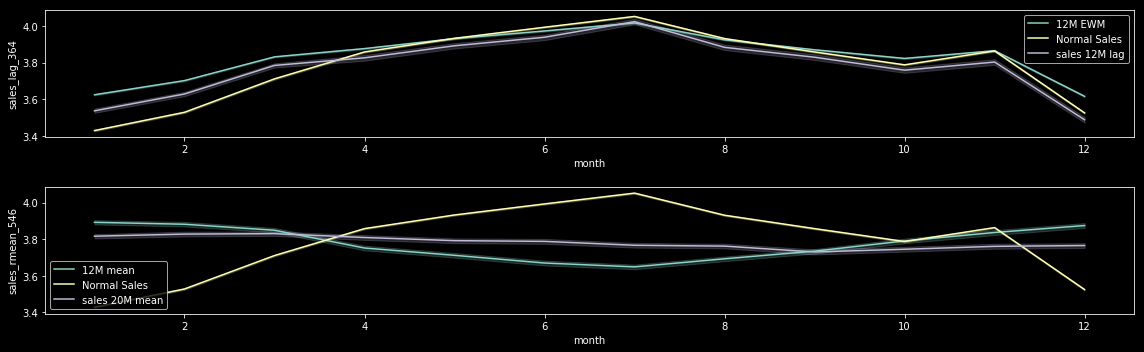

In [35]:
fig = plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
sns.lineplot(y='sales_lag_364_ewm_0.95', x='month',  data=train, label="12M EWM");
sns.lineplot(y='sales', x='month',  data=train, label="Normal Sales");
sns.lineplot(y='sales_lag_364', x='month',  data=train, label="sales 12M lag");
plt.legend()
plt.subplot(2,1,2)
sns.lineplot(y='sales_rmean_364', x='month',  data=train, label="12M mean");
sns.lineplot(y='sales', x='month',  data=train, label="Normal Sales");
sns.lineplot(y='sales_rmean_546', x='month',  data=train, label="sales 20M mean");
plt.tight_layout(h_pad=1.5)

** Using pandas to create dummies in order to enhance the performance of the LGB model**

In [36]:
train = pd.get_dummies(train, columns=['store','item','day_of_month','weekday','month'])
print('Shape after creating the dummies: {}'.format(train.shape))

Shape after creating the dummies: (820500, 188)


* Finally, separating the training set and validation set.

In [37]:
# Final train, validation and testing datasets
train_val = train.loc[train.split=='val', :]
train_X = train.loc[train.split=='train', :]
test_sub = train.loc[train.split == 'test',:]
print('Training shape:{}, Validation shape:{}, Labels X: {}, Labels Validation: {}, Testing shape: {}'
      .format(train_X.shape, train_val.shape,train_labels.shape,train_labels_val.shape, test_sub.shape))

Training shape:(730500, 188), Validation shape:(45000, 188), Labels X: (730500,), Labels Validation: (45000,), Testing shape: (45000, 188)


In [38]:
import time #implementing in this function the time spent on training the model
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb
import gc

####### FUNCTIONS FOR CALCULATING THE SMAPE LOSS ##########
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def train_model(X, X_val, y, y_val, params=None, model_type='lgb', plot_feature_importance=False, model=None):

    mask = ['date', 'sales', 'split', 'id', 'year']
    cols = [col for col in train.columns if col not in mask]
    evals_result={}
    if model_type == 'lgb':
        start = time.time()
        X_train = lgb.Dataset(data=X.loc[:,cols].values, label=y, 
                       feature_name=cols)
        
        X_valid = lgb.Dataset(data=X_val.loc[:,cols].values, label=y_val, 
                     reference=X_train, feature_name=cols)
        
        model = lgb.train(params, X_train, num_boost_round=params['num_boost_round'], 
                      valid_sets=[X_train, X_valid], feval=lgbm_smape, 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      evals_result=evals_result, verbose_eval=500)
            
        y_pred_valid = model.predict(X_val.loc[:, cols].values, num_iteration=model.best_iteration)
        y_pred_valid = np.expm1(y_pred_valid)
        y_val = np.expm1(y_val)
        
        end = time.time()
        
        #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        print('SMAPE validation data: {}'.format(smape(y_pred_valid, y_val)))
        
        if plot_feature_importance:
            # feature importance
            fig, ax = plt.subplots(figsize=(12,10))
            lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
            ax.grid(False)
            plt.title("LightGBM - Feature Importance", fontsize=15)
            
        print('Total time spent: {}'.format(end-start))
        return model
            
    if model_type == 'xgb':
        start = time.time()
        train_data = xgb.DMatrix(data=X.loc[:,cols].values, label=y)
        valid_data = xgb.DMatrix(data=X_val.loc[:,cols].values, label=y_val)

        watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
        model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, 
                          early_stopping_rounds=200, verbose_eval=500, params=params)
        
        y_pred_valid = model.predict(xgb.DMatrix(X_val.loc[:,cols].values), ntree_limit=model.best_ntree_limit)
        
        end = time.time()

        print('SMAPE validation data: {}'.format(smape(y_pred_valid, y_val)))
        
        print('Total time spent: {}'.format(end-start))
        return model
            
    if model_type == 'cat':
        start = time.time()
        model = CatBoostRegressor(eval_metric='MAE', **params)
        model.fit(X.loc[:,cols].values, y, eval_set=(X_val.loc[:,cols].values, y_val), 
                  cat_features=[], use_best_model=True)

        y_pred_valid = model.predict(X_val.loc[:,cols].values)
        
        print('SMAPE validation data: {}'.format(smape(y_pred_valid, y_val)))
        
        if plot_feature_importance:
            feature_score = pd.DataFrame(list(zip(X.loc[:,cols].dtypes.index, 
                                                  model.get_feature_importance(Pool(X.loc[:,cols], label=y, cat_features=[])))), columns=['Feature','Score'])
            feature_score = feature_score.sort_values(by='Score', kind='quicksort', na_position='last')
            feature_score[:50].plot('Feature', 'Score', kind='barh', color='c', figsize=(12,10))
            plt.title("Catboost Feature Importance plot", fontsize = 14)
            plt.xlabel('')
        
        end = time.time()

        print('Total time spent: {}'.format(end-start))
        return model
        
    # Clean up memory
    gc.enable()
    del model, y_pred_valid, X_test,X_train,X_valid, y_pred, y_train, start, end,evals_result
    gc.collect()



Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.137223	training's SMAPE: 14.0701	valid_1's l1: 0.139292	valid_1's SMAPE: 14.304
[1000]	training's l1: 0.132382	training's SMAPE: 13.5844	valid_1's l1: 0.136651	valid_1's SMAPE: 14.0381
[1500]	training's l1: 0.130462	training's SMAPE: 13.3909	valid_1's l1: 0.135441	valid_1's SMAPE: 13.9163
[2000]	training's l1: 0.129384	training's SMAPE: 13.2822	valid_1's l1: 0.134594	valid_1's SMAPE: 13.831
[2500]	training's l1: 0.128663	training's SMAPE: 13.2093	valid_1's l1: 0.134027	valid_1's SMAPE: 13.7738
[3000]	training's l1: 0.12813	training's SMAPE: 13.1555	valid_1's l1: 0.133654	valid_1's SMAPE: 13.7363
[3500]	training's l1: 0.127717	training's SMAPE: 13.1136	valid_1's l1: 0.13337	valid_1's SMAPE: 13.7077
[4000]	training's l1: 0.127367	training's SMAPE: 13.0782	valid_1's l1: 0.13318	valid_1's SMAPE: 13.6886
[4500]	training's l1: 0.127059	training's SMAPE: 13.047	valid_1's l1: 0.13301	valid_1's SMAPE: 13.6716


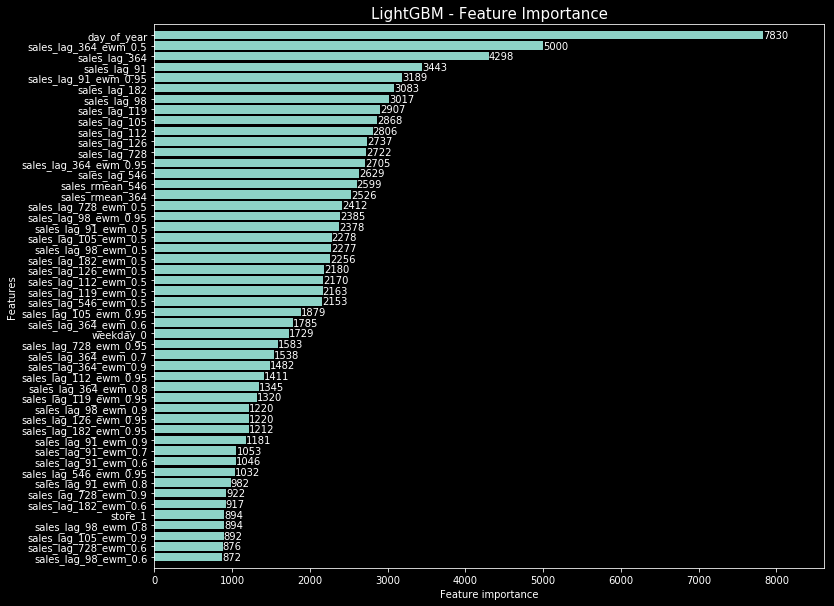

In [39]:
params = {
          'num_leaves': 10,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.02,
        'num_boost_round': 25000, 
        'early_stopping_rounds':200,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         'metric': 'mae',
         "lambda_l1": 0.2,
}
lgb_model = train_model(train_X,train_val,train_labels,train_labels_val,params, plot_feature_importance=True)

0:	learn: 3.6761886	test: 3.5902305	best: 3.5902305 (0)	total: 343ms	remaining: 11m 26s
50:	learn: 0.8084760	test: 0.7352325	best: 0.7352325 (50)	total: 13.8s	remaining: 8m 46s
100:	learn: 0.2408475	test: 0.1926143	best: 0.1926143 (100)	total: 25.6s	remaining: 8m 1s
150:	learn: 0.1599024	test: 0.1413999	best: 0.1413999 (150)	total: 37.1s	remaining: 7m 34s
200:	learn: 0.1473754	test: 0.1389913	best: 0.1389886 (199)	total: 48.4s	remaining: 7m 12s
250:	learn: 0.1430551	test: 0.1387769	best: 0.1387296 (231)	total: 59.6s	remaining: 6m 55s
300:	learn: 0.1406817	test: 0.1384344	best: 0.1384344 (300)	total: 1m 10s	remaining: 6m 39s
350:	learn: 0.1390234	test: 0.1381138	best: 0.1381118 (349)	total: 1m 22s	remaining: 6m 25s
400:	learn: 0.1377299	test: 0.1375815	best: 0.1375815 (400)	total: 1m 33s	remaining: 6m 13s
450:	learn: 0.1366858	test: 0.1372040	best: 0.1372040 (450)	total: 1m 45s	remaining: 6m 2s
500:	learn: 0.1358073	test: 0.1368200	best: 0.1368200 (500)	total: 1m 56s	remaining: 5m 49s
5

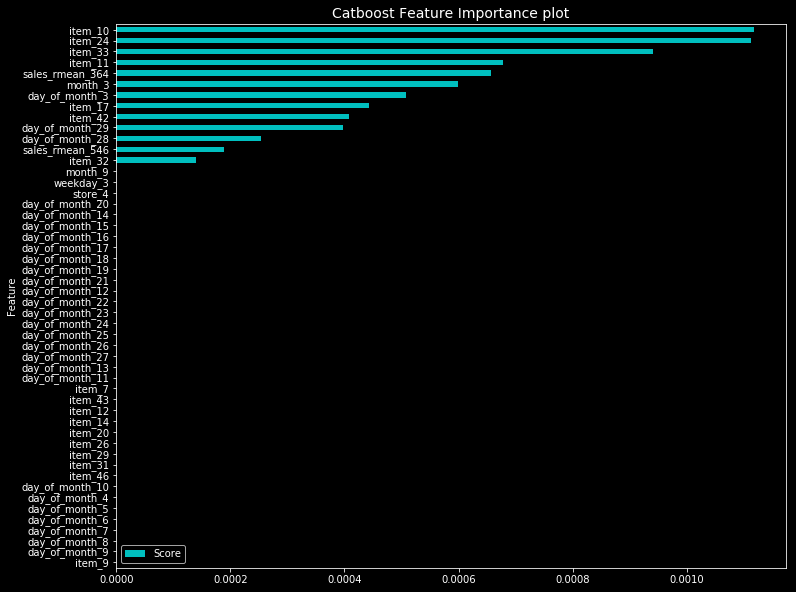

In [40]:
params_cat = {
    'iterations': 2000,
    'max_ctr_complexity': 6,
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 50,
    'verbose': 50,
    'depth': 4
}

cat_model = train_model(train_X,train_val,train_labels,train_labels_val,params_cat,model_type='cat', plot_feature_importance=True)

In [41]:
mask = ['date', 'sales', 'split', 'id', 'year']
cols = [col for col in train.columns if col not in mask]
predict_lgb = lgb_model.predict(test_sub.loc[:,cols].values, num_iteration=lgb_model.best_iteration)
predict_cat = cat_model.predict(test_sub.loc[:,cols].values)
predict_avg = (predict_lgb+predict_cat)/2
sub = pd.read_csv('../input/sample_submission.csv')
sub['sales'] = np.expm1(predict_avg)
sub.to_csv('lgb_model.csv', index=False)
sub.head()

,id,sales
0,0,24.649311
1,1,21.672393
2,2,17.112459
3,3,16.418581
4,4,15.778431
